## Predicting House Price in Seattle by XGBoost

### Table of Contents

<ul>
    <li><a href='#intro'>Introduction</a></li>
    <li><a href='#wrangling'>Data Wrangling</a></li>
    <li><a href='#eda'>Exploratory Data Analysis</a></li>
    <li><a href='#ml'>Machine learning</a></li>
    <li><a href='#conclusion'>Conclusion</a></li>
</ul>

<a id='intro'></a>
### Introduction

<a id='wrangling'></a>
### Data Wrangling

In [29]:
# import packages
import numpy as np
import pandas as pd

## visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL, space_eval
import pickle

1. Load house price dataset

In [3]:
# load dataset containing features and closing price of house
df = pd.read_csv('../Datasets/kc_house_data.csv')
print(df.shape)
df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  


- date: should be datetime

In [4]:
# Convert date to datetime using "month" as the unit
df1 = df.copy()
df1['date'] = df1['date'].str.slice(stop=-9)
df1['date'] = pd.to_datetime(df1['date'], format = '%Y%m')

In [30]:
df1.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-01,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-01,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-01,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-01,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-01,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [32]:
df1.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [33]:
df1.duplicated().sum()

0

2. Load mortgage rate dataset

In [5]:
# load dataset containing mortgage rates
mort_rates = pd.read_excel('../Datasets/historicalweeklydata.xls', sheet_name=1, na_values = ' ')
mort_rates.head()

,Week,30_FRM,30_fees_points,15_FRM,15_fees_points,5/1_ARM,5/1_fees_points
0,1971-04-02,7.33,NaN,NaN,NaN,NaN,NaN
1,1971-04-09,7.31,NaN,NaN,NaN,NaN,NaN
2,1971-04-16,7.31,NaN,NaN,NaN,NaN,NaN
3,1971-04-23,7.31,NaN,NaN,NaN,NaN,NaN
4,1971-04-30,7.29,NaN,NaN,NaN,NaN,NaN


In [35]:
mort_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2597 entries, 0 to 2596
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Week             2597 non-null   datetime64[ns]
 1   30_FRM           2597 non-null   float64       
 2   30_fees_points   2565 non-null   float64       
 3   15_FRM           1532 non-null   float64       
 4   15_fees_points   1532 non-null   float64       
 5   5/1_ARM          835 non-null    float64       
 6   5/1_fees_points  835 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 142.1 KB


In [6]:
# create a column with monthly data
mort_rates['MonthYear'] = mort_rates['Week'].dt.strftime('%Y-%m-%d')
mort_rates['MonthYear'] = mort_rates['MonthYear'].str.slice(stop=-3)
mort_rates['MonthYear'] = pd.to_datetime(mort_rates['MonthYear'], format = '%Y-%m')
# calculate the monthly average
mort = mort_rates.groupby('MonthYear', as_index=False).mean()
mort = mort[['MonthYear', '30_FRM', '15_FRM']].copy()
mort.head()

,MonthYear,30_FRM,15_FRM
0,1971-04-01,7.3100,NaN
1,1971-05-01,7.4250,NaN
2,1971-06-01,7.5300,NaN
3,1971-07-01,7.6040,NaN
4,1971-08-01,7.6975,NaN


3. Add an additional variable (30-year fix mortgage rate) to the main dataset

In [7]:
# join df and mort based on date

df2 = df1.merge(mort, left_on = 'date', right_on = 'MonthYear')
df2.drop(columns = ['id', 'MonthYear', 'date'], inplace=True)
print(df2.shape)
df2.head()

(21613, 21)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,30_FRM,15_FRM
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,4.036,3.21
1,400000.0,3,1.75,1370,9680,1.0,0,0,4,7,...,0,1977,0,98074,47.6127,-122.045,1370,10208,4.036,3.21
2,685000.0,3,1.00,1570,2280,2.0,0,0,3,7,...,0,1922,0,98119,47.6413,-122.364,1580,2640,4.036,3.21
3,505000.0,3,1.75,2519,8690,2.0,0,0,5,8,...,0,1973,0,98166,47.4428,-122.344,2500,9500,4.036,3.21
4,287000.0,4,2.50,2240,4648,2.0,0,0,3,7,...,0,2005,0,98001,47.3378,-122.257,2221,4557,4.036,3.21


In [8]:
df2.to_csv('../Datasets/kc_house_data_updated.csv', index=False)

In [9]:
df2 = pd.read_csv('../Datasets/kc_house_data_updated.csv')
df2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,30_FRM,15_FRM
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,4.036,3.21
1,400000.0,3,1.75,1370,9680,1.0,0,0,4,7,...,0,1977,0,98074,47.6127,-122.045,1370,10208,4.036,3.21
2,685000.0,3,1.00,1570,2280,2.0,0,0,3,7,...,0,1922,0,98119,47.6413,-122.364,1580,2640,4.036,3.21
3,505000.0,3,1.75,2519,8690,2.0,0,0,5,8,...,0,1973,0,98166,47.4428,-122.344,2500,9500,4.036,3.21
4,287000.0,4,2.50,2240,4648,2.0,0,0,3,7,...,0,2005,0,98001,47.3378,-122.257,2221,4557,4.036,3.21


In [40]:
df2.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,30_FRM,15_FRM
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,...,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,3.972466,3.160356
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,...,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,0.193983,0.122740
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,3.670000,2.942000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,3.770000,3.040000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,4.036000,3.210000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,4.162500,3.265000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,4.192000,3.307500


<a id='eda'></a>
### Exploratory Data Analysis

In [13]:
def distribution(df):
    fig = plt.figure(figsize=[20, 20])
    for i in range(len(df.columns)):
        fig.add_subplot(int(np.ceil(len(df.columns)/4)), 4, i+1)
        sns.histplot(df.iloc[:, i], kde=True)
        plt.tight_layout()

Distribution of independent variables

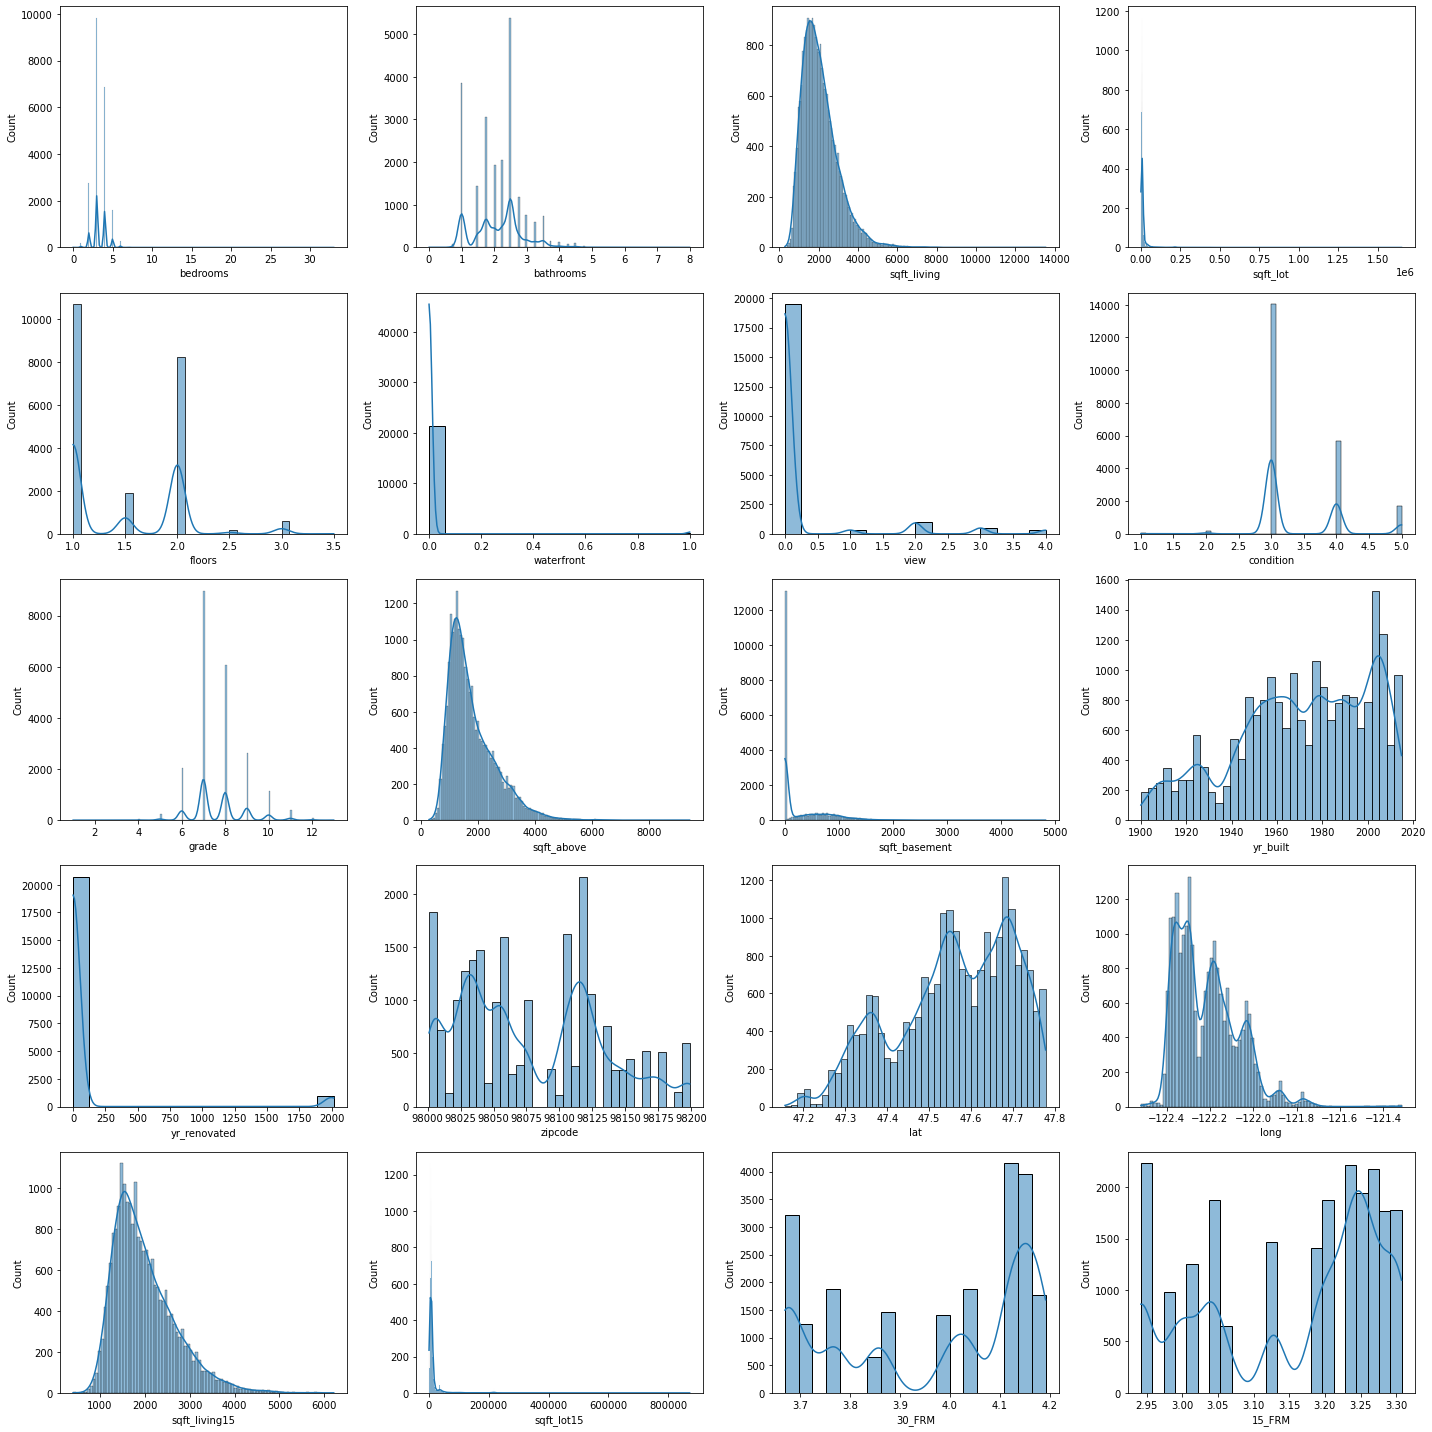

In [14]:
distribution(df2.drop(columns = ['price']))

Distribution of price

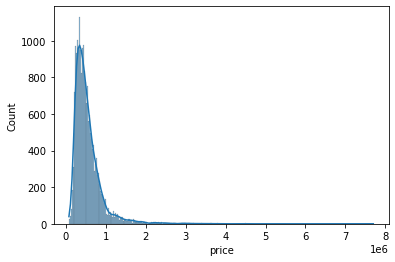

In [44]:
sns.histplot(df2['price'], kde=True);

<AxesSubplot:xlabel='price'>

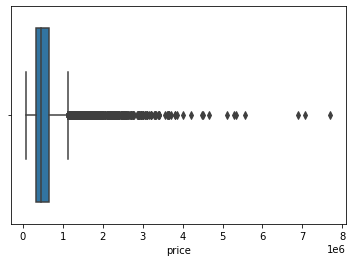

In [17]:
sns.boxplot(x = df2['price'])

**Remove the outliers**

In [15]:
def rm_outliers(df, column_name):
    df_stats = df.describe()
    Q3 = df_stats.loc['75%', column_name]
    Q1 = df_stats.loc['25%', column_name]
    IQ = Q3 - Q1
    df_new = df[~((df[column_name] < (Q1 - 1.5 * IQ)) | (df[column_name] > (Q3 + 1.5 * IQ)))].copy()
    return df_new

In [16]:
df3 = rm_outliers(df2, 'price')

<AxesSubplot:xlabel='price'>

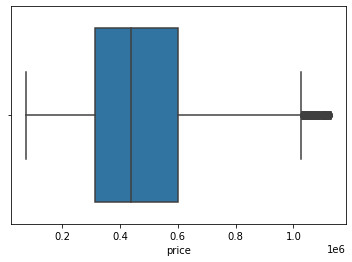

In [18]:
sns.boxplot(x = df3['price'])

Relationship between price and independent variables

In [19]:
def scatter(df):
    fig = plt.figure(figsize=[20, 20])
    for i in range(len(df.columns)):
        fig.add_subplot(int(np.ceil(len(df.columns)/4)), 4, i+1)
        sns.scatterplot(x = df.iloc[:, i], y = df_responsor)
        plt.tight_layout()

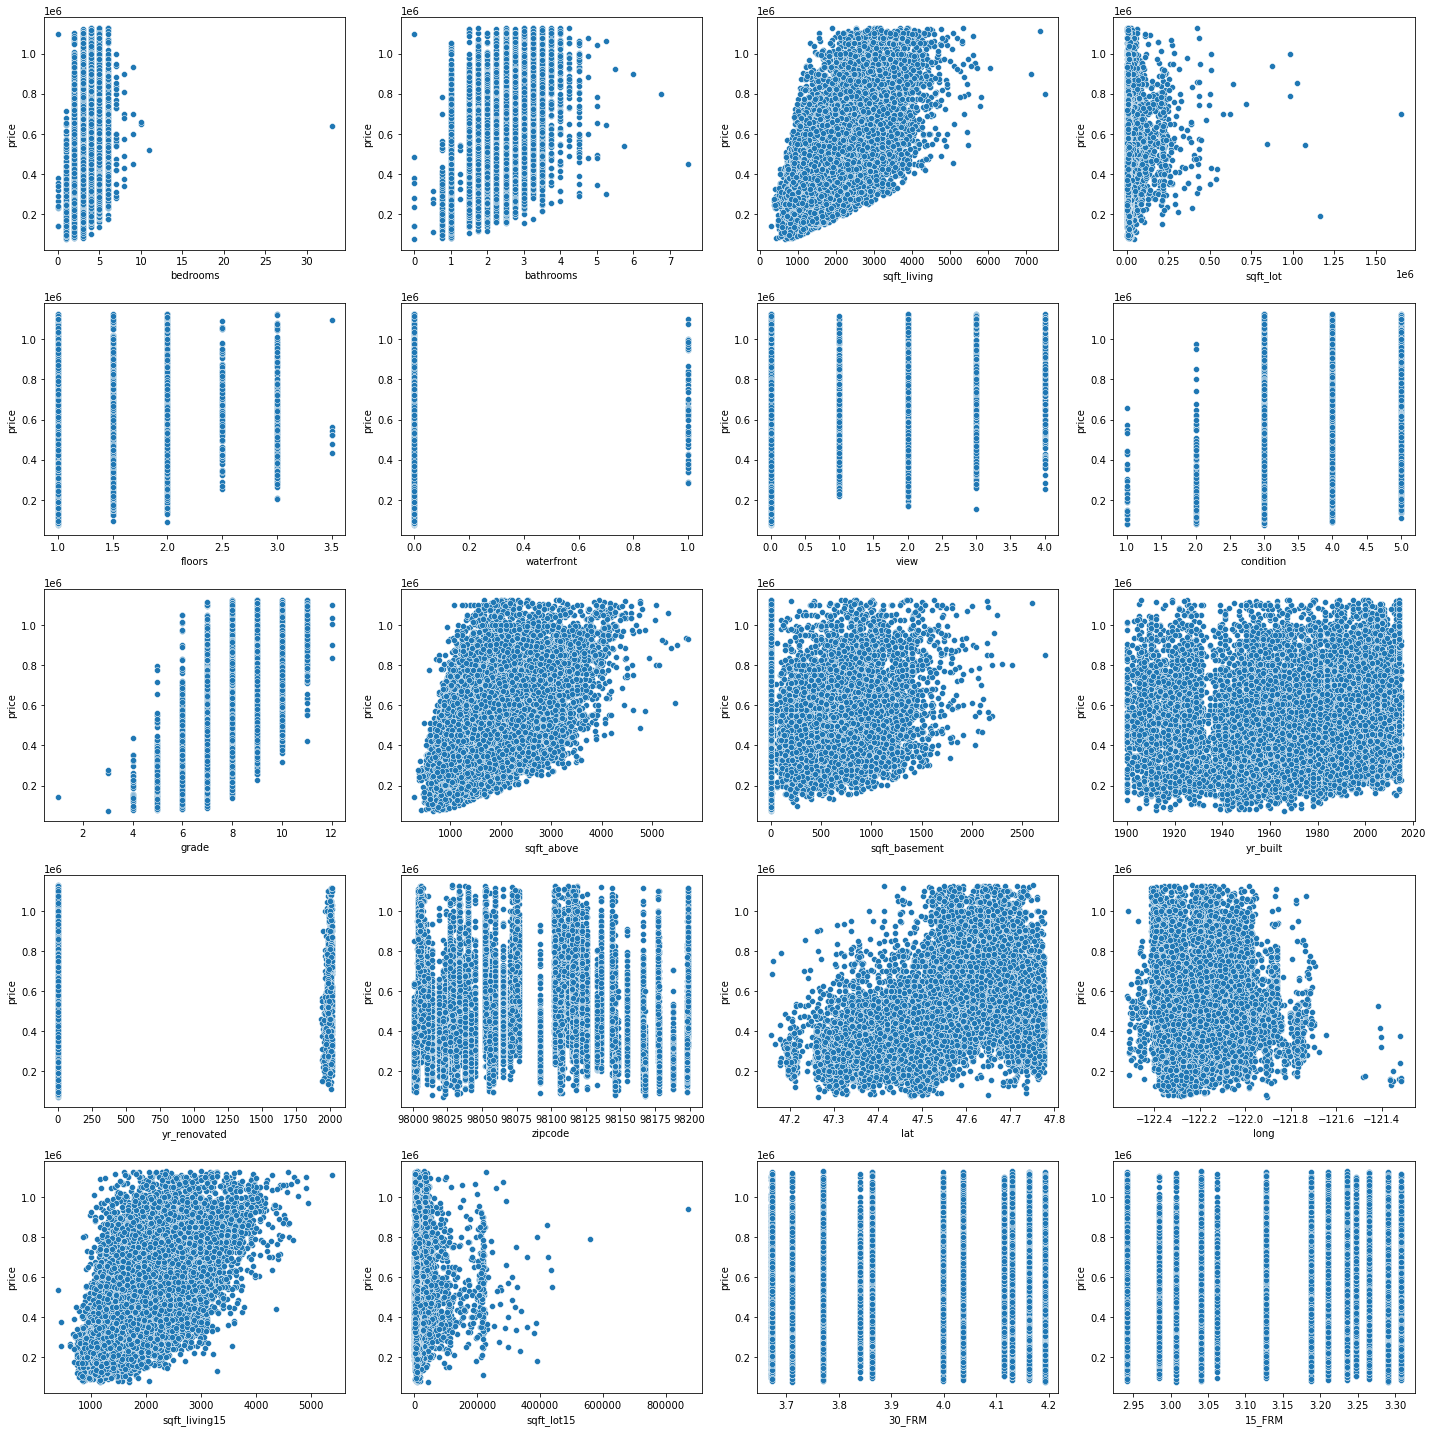

In [20]:
scatter(df3.drop(columns = ['price']))

In [21]:
df_predictor = df3.drop(columns = ['price']).copy()
df_responsor = df3['price'].copy()

<a id='ml'></a>
### Machine Learning

Model: XGBoost

In [22]:
y = df_responsor
X = df_predictor

In [25]:
# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 28)
# split fitting and validating data for parameter tuning
X_fit, X_valid, y_fit, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=28)

1. Parameter tuning

In [24]:
def hyper_param_tuning(estimator_name,
                       paramSpace,
                       loss,
                       X_fit, 
                       y_fit,
                       X_valid,
                       y_valid,
                       max_evals=20):
    '''
        Parameter tuning using Hyperopt package
        INPUTS:
            estimator_name: model to tune
            paramSpace: dict, space of parameters to test on for model
            loss: loss function
            X_fit: train data features
            y_fit: train data target
            X_valid: vaildation data features
            y_valid: validation data target
            max_evals: the maximum number of evaluations  
        OUTPUT:
            Python dictionary with hyperparameter as the key, optimized value as the values
    '''

    # objective function for fmin
    def objective(paramSpace):
        try:
            estimator = estimator_name(**paramSpace)

            # fit
            estimator.fit(X_fit, y_fit)

            loss_ = loss(y_valid, estimator.predict(X_valid))

            return {'loss': loss_, 'status': STATUS_OK, 'Trained_Model': estimator}

        except Exception as e:
            print(e)
            print('Training fail')
            return {'loss': np.nan, 'status': STATUS_FAIL, 'Trained_Model': None}

    trials = Trials() # store the evaluation results at each step
    best = fmin(fn=objective, # objective function to optimize
                space=paramSpace, # parameter space to search
                algo=tpe.suggest, # search mechanism: tree of Parzen estimators (sequential model based optimization)
                max_evals=max_evals,
                trials=trials, # database to store evaluations
                rstate=np.random.RandomState(0)) 

    return space_eval(paramSpace, best)

In [38]:
paramSpace = {'n_estimators': hp.choice('n_estimators', [400, 600, 800]),
              'max_depth': hp.choice('max_depth',[4, 6, 8]),
              'min_child_weight': hp.choice('min_child_weight',[1, 2, 3]), # minimum sum of weight in a child
              'gamma': hp.uniform('gamma', 0, 0.1), # minimum loss reduction after a leaf node
              'reg_lambda': hp.uniform('reg_lambda', 1, 3), # L2 regularization, decrease the leaf value
              'reg_alpha': hp.uniform('reg_alpha', 0, 0.6), # L1 regularization, make leaf value approach 0
              'subsample': hp.uniform('subsample', 0.9, 1), # subsample ratio
              'learning_rate': hp.uniform('learning_rate', 0.03, 0.2)} # shrinkage size to update feature weight

best_estimator= hyper_param_tuning(xgb.XGBRegressor, paramSpace, mean_absolute_percentage_error, X_fit, y_fit, X_valid, y_valid, max_evals=50)

100%|██████████| 50/50 [07:43<00:00,  9.28s/trial, best loss: 0.11412886207274361]


In [39]:
best_estimator

{'gamma': 0.07727247346328645,
 'learning_rate': 0.05767302422076337,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 800,
 'reg_alpha': 0.5450630242019845,
 'reg_lambda': 2.9578073168527226,
 'subsample': 0.9258371661972749}

2. Evaluation

In [40]:
xgbt = xgb.XGBRegressor(**best_estimator)
xgbt.fit(X_train, y_train)
y_pred = xgbt.predict(X_test)

mean_absolute_percentage_error(y_test, y_pred)

0.11121430365832972

In [41]:
filepath = '../Web application/pages/estimator.sav'
pickle.dump(xgbt, open(filepath, 'wb'))

In [42]:
xgbt = pickle.load(open(filepath, 'rb'))

<a id='conclusion'></a>
### Conclusion